# PHYS 247 Final: Restaurant Revenue Prediction

## Luis A. Hernandez

**Problem description:**

Based off of a publicly available dataset from Kaggle, the aim of this project is to predict annual restaurant revenue sales based on objective measurements. Covering multiple steps in the process, the data will first be explored and visually displayed to see if there are any intersting insights. Then, the data will be prepared using machine learning models to compensate for missing data and pinpoint the critical variables that can be considered for analysis. Finally, a linear regression modeling method will be applied to predict annual revenue restaurant sales.

In [1]:
#Define dependencies.
import pandas as pd
from geopy.geocoders import Nominatim
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import scipy
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.cluster import KMeans

In [2]:
#Import datasets.
restaurant_train = pd.read_csv('train.csv')
restaurant_test = pd.read_csv('test.csv')

In [3]:
#Let's see what columns we have available, and if they coincide with those provided on kaggle.
restaurant_train.columns.values

array(['Id', 'Open Date', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3',
       'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13',
       'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22',
       'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31',
       'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'revenue'], dtype=object)

In [4]:
#Quick view of our data.
restaurant_train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


We can see that our data set coincides well with the parameters displayed on Kaggle; we can also see that the cities displayed are mostly in Turkey. Let's see if they are all really located in Turkey and where these reports are most prevalent from. 

### Data Exploration

Seeing that we are considering the training set for evaluation, I will start off by seeing how the restaurant scene is represented in this dataset. 

#### Map visualization: Report location and prevalence.

Using the dataset, unknown values are withdrawn and python's geopy package is used to generate the coordinates for the cities available. Having the intention to obtain some form of map visualization, the overall counts for reports from the cities are summed and added to the subset. Once generated, python's cartopy package is used to display the data in the resultant map, to which we can see that the majority is indeed in Turkey.

In [5]:
#Obtain the total amount of cities involved in this dataset.
tcities = pd.DataFrame({'City':restaurant_train['City'].drop_duplicates().reset_index(drop=True)})

In [6]:
#Remove the unknown city.
tcities = tcities[tcities['City'] != 'Tanımsız'].reset_index(drop=True)

In [7]:
#Set up geolocator to generate coordinates using geopy.
geolocator = Nominatim(user_agent = 'personal_email')
#Store city coordinates which are generated using geopy.
city_coords = [geolocator.geocode(tcities['City'][i]) for i in range(len(tcities))]

In [8]:
#Distinguish between latitudes and longitudes.
city_lng = [i[1][0] for i in city_coords]
city_lat = [i[1][1] for i in city_coords]

In [9]:
#Store latitutdes and longitudes for cities in the dataset.
tcities['lng'] = city_lng
tcities['lat'] = city_lat

In [10]:
#Order by city.
tcities = tcities.sort_values(by=['City']).reset_index(drop=True)

In [11]:
#Calculate the total count for each city.
true_tcities = restaurant_train['City']
true_tcities = true_tcities[true_tcities != 'Tanımsız']
true_tcities = [i for i in true_tcities.value_counts().sort_index()]

In [12]:
#Insert the count into the city dataframe.
tcities['city_count'] = true_tcities

In [13]:
#Quick display of the city subset dataframe. 
tcities.sort_values(by=['city_count'], ascending = False).head()

,City,lng,lat,city_count
31,İstanbul,41.009633,28.965165,50
3,Ankara,39.920789,32.854041,19
32,İzmir,38.414733,27.143412,9
8,Bursa,40.182766,29.067730,5
26,Samsun,41.289233,36.328565,5


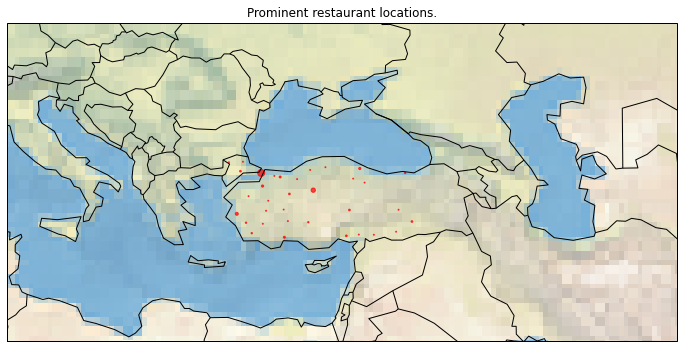

In [14]:
#Generate map visualization for this data.
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(1,1,1, projection=crs.Miller())

ax.stock_img()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

#up_left = 42.160610, 25.815575
#low_left = 35.499846, 25.816005
#up_right = 42.431979, 46.815854
#low_right = 34.953535, 46.581780

ax.set_extent([10, 60, 30, 50], crs = crs.PlateCarree())

plt.scatter(x = tcities.lat, y = tcities.lng, color = 'red', s=tcities.city_count, alpha=0.7, transform=crs.PlateCarree())
plt.title('Prominent restaurant locations.')
plt.show()

#### Revenue generating cities

In [15]:
#Filter dataset to city and revenue columns.
rev_city = restaurant_train[['City','revenue']]

In [16]:
#Generate a list of unique cities to be used for the revenue filter.
city = rev_city['City'].drop_duplicates().sort_values().tolist()

In [17]:
#Group revenues by city.
tcity = rev_city.groupby('City')

In [18]:
#Generate list of revenues for each unique city.
rev_city = [sum(tcity.get_group(i)['revenue']) for i in city]

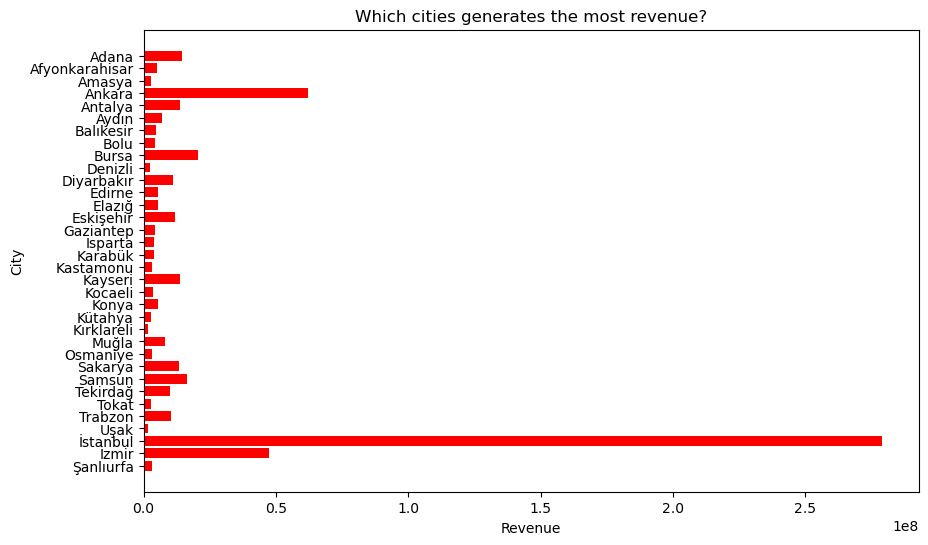

In [19]:
#Generate horizontal bar plot to see which city generates the most revenue.
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,6))
y_pos = np.arange(len(city))

ax.barh(y_pos,rev_city, color ='r')
ax.set_ylabel('City')
ax.set_yticks(y_pos)
ax.set_yticklabels(city)
ax.invert_yaxis()
ax.set_xlabel('Revenue')
ax.set_title('Which cities generates the most revenue?')

plt.show()

By an overwhelming majority, the main part of the dataset consists of restaurants in the Istanbul region of the country. But how does this impact, if at all, the type of restaurants that may be present. In this next section, this will be displayed.

#### Revenue generating restaurant types

In [20]:
#Store the necessary columns for this part.
rev_type = restaurant_train[['Type','revenue']]

In [21]:
#Consolidate the 'Type' features.
rtype = rev_type['Type'].drop_duplicates().tolist()

In [22]:
#Group the values by 'Type'
ttype = rev_type.groupby('Type')

In [23]:
#Sum and store the revenues by 'Type'
rev_type = [sum(ttype.get_group(i)['revenue']) for i in rtype]

In [24]:
#Store the complete 'Type' names.
rtype = ['Inline', 'Food Court', 'Drive Thru']

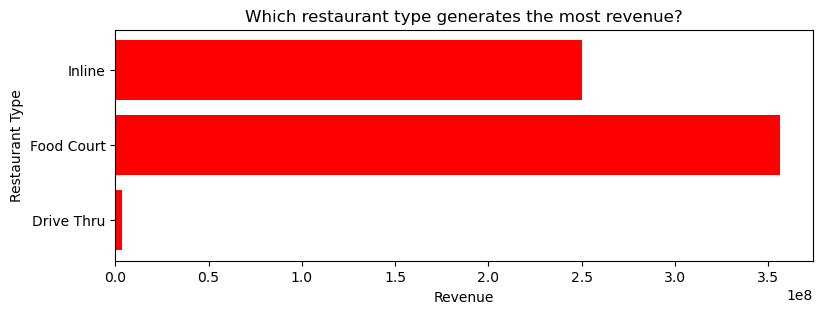

In [25]:
#Generate horizontal bar plot to see which restaurant type generates the most revenue.
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(9,3))
y_pos = np.arange(len(rtype))

ax.barh(y_pos,rev_type,color='r')
ax.set_ylabel('Restaurant Type')
ax.set_yticks(y_pos)
ax.set_yticklabels(rtype)
ax.invert_yaxis()
ax.set_xlabel('Revenue')
ax.set_title('Which restaurant type generates the most revenue?')

plt.show()

Interestingly, the restaurant type in the country consists of Food Courts as we can see in the bar chart above. Another additional point that can be added is that the mobile (MB) category is missing, which will be compensated for in the data preparation section in order to reach comprehensive results.

#### Prominent restaurant launch dates

So, we have indeed seen that the restaurants considered in this dataset are primarily in Turkey. Next, let's see if there is a trend in the launch dates of restaurants. Eliminating the day itself, I have concatenated the training and test dataset to have a more full picture.

In [26]:
#Concatenate both datasets.
tot = restaurant_train

In [27]:
#Store months and years in lists.
month = [i.split('/')[0] + '/' for i in tot['Open Date']]
year = [i.split('/')[2] for i in tot['Open Date']]

In [28]:
#Generate a new dataframe for this part of the exploration.
odate = pd.DataFrame([x+y for x,y in zip(month,year)], columns = ['date']).sort_values(by=['date'])
odate = odate.reset_index(drop=True)

In [29]:
#Transform 'date' column to datetime format in order to accurately sort the dates, 
#then send it back as a string.
odate['date'] = pd.to_datetime(odate['date'])
odate = odate.sort_values(by='date').reset_index(drop=True)
odate['date'] = [str(i)[:7] for i in odate['date']]

In [30]:
#Store the counts for each date considered, preparing it for a bar plot.
date_count = [i for i in odate['date'].value_counts().sort_index()]

In [31]:
#Minimize dataset to one entry per date to match the corresponding counts previously calculated.
odate = odate.drop_duplicates().reset_index(drop=True)

In [32]:
#Import the counts into the date subset dataset.
odate['date_count'] = date_count

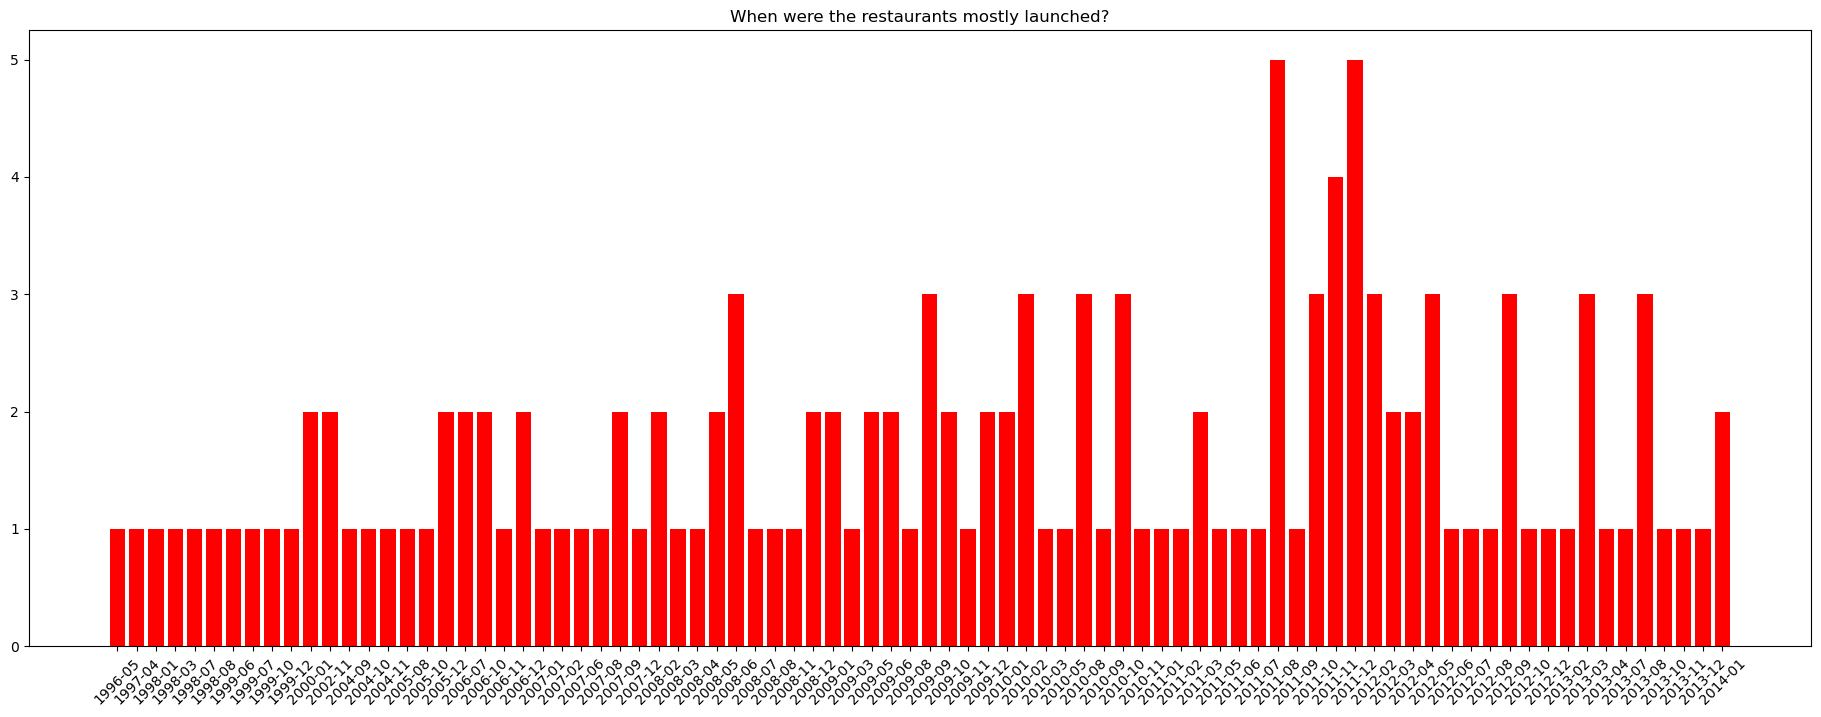

In [33]:
#Display the trend in a barplot.
plt.figure(figsize=(23,8))
plt.bar(odate['date'],odate['date_count'],color='r')
plt.title('When were the restaurants mostly launched?')
plt.xticks(rotation='45')
plt.show()

With the majority of the launch dates consisting of those in the early 2010's, the dataset seems to behave consistently as time has gone by.

#### Correlation

The insights obtained so far have given us a more clear picture of the behaviors of this particular market in the country of Turkey, however, let's see if there are any relationships among the different variables available through a correlation map. 

In [34]:
restaurant_corr = restaurant_train.corr()

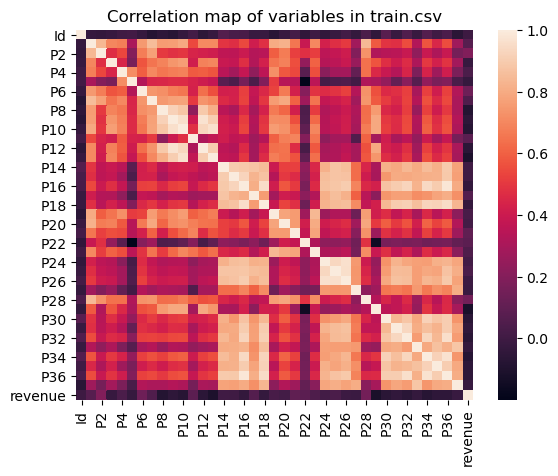

In [35]:
sn.heatmap(restaurant_corr)
plt.title('Correlation map of variables in train.csv')
plt.show()

With an indication of strong ties being held in the lower right of the diagram, this will be a good signal to be aware of later on in the data preparation section. Before moving on though, I would like to see if the data is sufficiently normally distributed to apply the final analysis method-linear regression-through a Q-Q plot.

#### Q-Q Plot

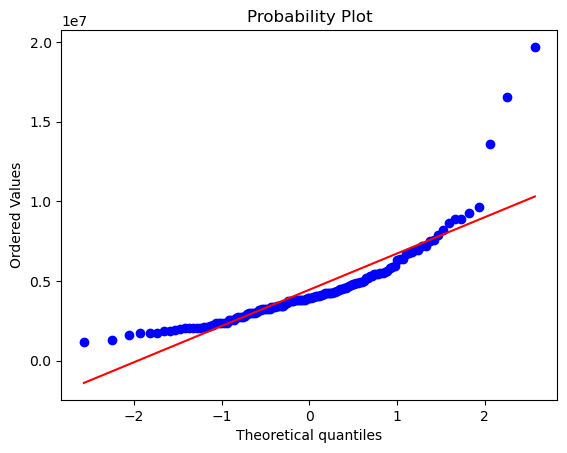

In [36]:
#Q-Q plot for the 'revenue' target variable to see if data is normalized.
scipy.stats.probplot(restaurant_train['revenue'], dist = 'norm', plot=plt)
plt.show()

Seeing that the data has some skewness when plotting the Q-Q plot and some outlier data points, what would makes sense to do is to transform this variable to see if we can get a better result. For this reason, a logarithm was applied on the revenue and was implemented in the following sections; additionally, since the amount of data is already limited, I decided to not delete the outliers, that can be better seen in a boxplot below.

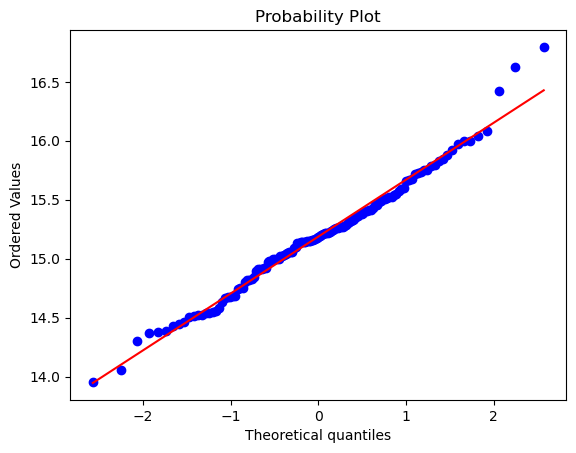

In [37]:
#Q-Q plot of the logarithm of the 'revenue' variable.
scipy.stats.probplot(np.log(restaurant_train['revenue']), dist='norm', plot=plt)
plt.show()

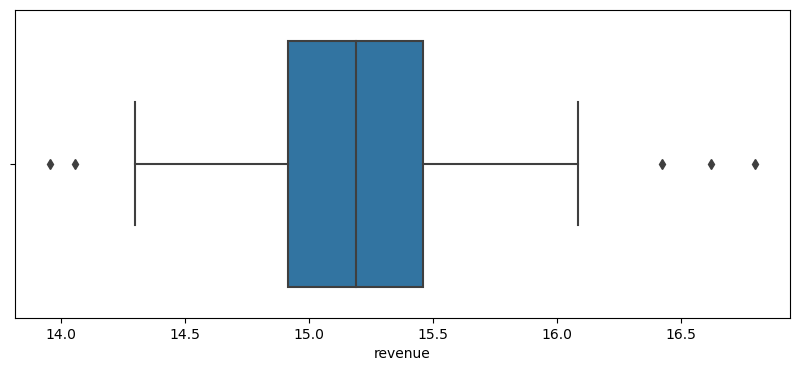

In [38]:
#Box-plot displaying the present outliers.
plt.figure(figsize=(10,4))
sn.boxplot(np.log(restaurant_train['revenue']))
plt.show()

### Data Preparation

So far, the data has been explored to become familiar with the information available. The next step now is to prepare the data for the analysis portion. Seeing that there are columns with categorical variables that perhaps could still be considered, let's transform those to dummy variables to fully descard them in the following step - principle component analysis.

In [39]:
#First column that needs to be transformed from a categorical variable to a numerical one.
restaurant_train['City Group'].drop_duplicates()

0    Big Cities
2         Other
Name: City Group, dtype: object

In [40]:
#Replace the column values with 0 if it is a 'Big City' data point, otherwise place a 1, 
#and store these values into the same column.
restaurant_train['City Group'] = [1 if i == 'Other' else 0 for i in restaurant_train['City Group'].tolist()]

In [41]:
#Second column that needs to be transformed from a categorical variable to a numerical one.
restaurant_train['Type'].drop_duplicates()

0      IL
1      FC
124    DT
Name: Type, dtype: object

Since this second column is a little more challenging due to the multiple data point values available, it can still be done with dummy variables; but given that there is a difference in the data available between the training set and the testing set, a compensation method must be implemented to account for those unknowns via KNN. Before that though, let's keep preparing the restaurant training set and move onto that part.

In [42]:
#Set the dummy variables for the 'type' column.
restaurant_train['Type'] = [int(3) if k == 'DT' else k for k in [int(2) if j == 'IL' else j for j in [int(1) if i == 'FC' else i for i in restaurant_train['Type']]]]

In [43]:
#One last thing to consider is the date, 
#and since this is a string, I will cut it down to just the year and transform it to an int.
restaurant_train[['month','day','year']] = restaurant_train['Open Date'].str.split('/',expand=True)
restaurant_train['year'] = [int(i) for i in restaurant_train['year']]
restaurant_train['month'] = [int(i) for i in restaurant_train['month']]
restaurant_train['day'] = [int(i) for i in restaurant_train['day']]

In [44]:
#Dataset is ready for PCA section and beyond.
restaurant_train = restaurant_train.iloc[:,3:]
restaurant_train.head()

,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,...,P32,P33,P34,P35,P36,P37,revenue,month,day,year
0,0,2,4,5.0,4.0,4.0,2,2,5,4,...,4,5,5,4,3,4,5653753.0,7,17,1999
1,0,1,4,5.0,4.0,4.0,1,2,5,5,...,0,0,0,0,0,0,6923131.0,2,14,2008
2,1,2,2,4.0,2.0,5.0,2,3,5,5,...,0,0,0,0,0,0,2055379.0,3,9,2013
3,1,2,6,4.5,6.0,6.0,4,4,10,8,...,10,6,18,12,12,6,2675511.0,2,2,2012
4,1,2,3,4.0,3.0,4.0,2,2,5,5,...,3,2,3,4,3,3,4316715.0,5,9,2009


#### KNN imputation for dataset variable compensation

In [45]:
#Let's make a copy of the test set.
res_test = restaurant_test.copy()

In [46]:
#Now let's start forming our dataset to match that of the training set, 
#with the exception of the revenue column for the analysis.
res_test[['month','day','year']] = res_test['Open Date'].str.split('/',expand=True)
res_test['year'] = [int(i) for i in res_test['year']]
res_test['month'] = [int(i) for i in res_test['month']]
res_test['day'] = [int(i) for i in res_test['day']]

In [47]:
#Replicate dummy variable for the city group variable.
res_test['City Group'] = [1 if i == 'Other' else 0 for i in res_test['City Group']]

In [48]:
#Replicate the dummy variable process for the 'type' column.
res_test['Type'] = [int(3) if k == 'DT' else k for k in [int(2) if j == 'IL' else j for j in [int(1) if i == 'FC' else i for i in res_test['Type']]]]

In [49]:
#Since this dataset is the one that contains the mobile option (MB), 
#then I will be setting this as null in order to find and compensate for it in the next steps.
res_type = [np.nan if i == 'MB' else i for i in res_test['Type']]

In [50]:
#Substitute back in for the 'type' column in the main dataframe.
res_test['Type'] = res_type

In [51]:
#Let's see what it looks like!
knni_test = res_test.iloc[:,3:]
knni_test.head()

,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,...,P31,P32,P33,P34,P35,P36,P37,month,day,year
0,1,1.0,1,4.0,4.0,4.0,1,2,5,4,...,0,0,0,0,0,0,0,1,22,2011
1,1,2.0,3,4.0,4.0,4.0,2,2,5,3,...,0,0,0,0,0,0,0,3,18,2011
2,0,1.0,3,4.0,4.0,4.0,2,2,5,4,...,0,0,0,0,0,0,0,10,30,2013
3,1,2.0,2,4.0,4.0,4.0,2,3,5,4,...,4,0,0,0,0,0,0,5,6,2013
4,1,1.0,2,4.0,4.0,4.0,1,2,5,4,...,0,0,0,0,0,0,0,7,31,2013


As previously mentioned, the test dataset has the mobile option (MB) available, while the training set is missing it. In order to compensate for this, I have used the KNNImputer function that is available in the scikit learn library.

In [52]:
#Define the KNNImputer function.
imputer = KNNImputer()

In [53]:
#Send data to the KNNImputer
imputer.fit(knni_test)

KNNImputer()

In [54]:
#Store the transformed data once sent to the KNNImputer
knni_sol = imputer.transform(knni_test)

In [55]:
#Format the resultant dataframe from the data received.
knni_test = pd.DataFrame(knni_sol, columns = [i for i in knni_test.columns.values])

In [56]:
#Now that the dataframe is updated to compensate for the mobile (MB) option of the 'type' column,
#let's quickly see what values are available and if they coincide with those available on the training dataset.
knni_test['Type'].drop_duplicates()

0        1.0
1        2.0
35       3.0
543      1.2
1001     1.4
1444     1.8
4117     1.6
45034    2.4
Name: Type, dtype: float64

In [57]:
#Given that the values available are floats with decimal values in between the values allowed,
#this will be fixed by setting boundaries that will output corresponding dummy variables to those in the training set.
knni_test['Type'] = [2.0 if (j >= 1.5 and j < 2.5) else j for j in [1 if (i > 1 and i < 1.5) else i for i in knni_test['Type']]]

In [58]:
knni_test.head()

,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,...,P31,P32,P33,P34,P35,P36,P37,month,day,year
0,1.0,1.0,1.0,4.0,4.0,4.0,1.0,2.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.0,2011.0
1,1.0,2.0,3.0,4.0,4.0,4.0,2.0,2.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,18.0,2011.0
2,0.0,1.0,3.0,4.0,4.0,4.0,2.0,2.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,30.0,2013.0
3,1.0,2.0,2.0,4.0,4.0,4.0,2.0,3.0,5.0,4.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6.0,2013.0
4,1.0,1.0,2.0,4.0,4.0,4.0,1.0,2.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,31.0,2013.0


We can now see that the two datasets agree with each other on the variables available, with the exception of the response/target variable, namely 'revenue'. With this in place, the next thing to figure out is to see what variables are vital for the main analysis-predicting revenue-which will be carried out through a Principal Component Analysis. 

#### K-means clustering for city compensation (pending)

In [59]:
res_train = pd.read_csv('train.csv')

In [60]:
len(res_train['City'].drop_duplicates())

34

In [61]:
len(res_test['City'].drop_duplicates())

57

#### Data normalization

Before the Principal Component Analysis (PCA) is performed though, the data needs to be scaled in order for all of the variables to have a more fully balanced dataset that will give the most accurate results. As it was mentioned in the data exploration part though, the 'revenue' target feature seems to be more fully normalized when taking it's logarithm. So, just before this normalization, let's take the logarithm of that column and reinstate it in the dataframe.

In [62]:
rtrain_y = restaurant_train['revenue'].copy()
rtrain_y

0      5653753.0
1      6923131.0
2      2055379.0
3      2675511.0
4      4316715.0
         ...    
132    5787594.0
133    9262754.0
134    2544857.0
135    7217634.0
136    6363241.0
Name: revenue, Length: 137, dtype: float64

In [63]:
#Take the logarithm of the 'revenue' column to generate better results.
restaurant_train['revenue'] = np.log(restaurant_train['revenue'])

In [64]:
#Store the response variable for the training set.
rtrain_ylog = restaurant_train['revenue']
rtrain_ylog

0      15.547830
1      15.750379
2      14.535971
3      14.799651
4      15.278005
         ...    
132    15.571227
133    16.041512
134    14.749585
135    15.792038
136    15.666048
Name: revenue, Length: 137, dtype: float64

In [65]:
#Update the feature dataset.
restaurant_train.drop(columns=['revenue'], inplace=True)

In [66]:
#Generate a StandardScaler instance.
scaler = StandardScaler()

In [67]:
#Transform the data to be normalized.
rtrain_x = scaler.fit_transform(restaurant_train)

In [68]:
#Generate a dataframe with the same previous column titles for the training set, but with normalized data.
rtrain_x = pd.DataFrame(rtrain_x, columns = [i for i in restaurant_train.columns.values])

In [69]:
#Let's take a quick look of the training dataset.
rtrain_x.head()

,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,...,P31,P32,P33,P34,P35,P36,P37,month,day,year
0,-0.869718,1.068814,-0.005034,0.391716,-0.308701,-0.367578,-0.006056,-0.638471,-0.185001,-0.622801,...,0.302463,0.282950,2.281657,0.487922,0.575634,0.189821,1.615951,-0.016322,0.262590,-2.412090
1,-0.869718,-0.883553,-0.005034,0.391716,-0.308701,-0.367578,-0.835796,-0.638471,-0.185001,-0.082777,...,-0.554863,-0.484658,-0.672851,-0.483667,-0.592690,-0.532553,-0.625925,-1.413891,-0.075731,-0.169174
2,1.149797,1.068814,-0.694749,-0.270816,-2.253162,0.619837,-0.006056,-0.168199,-0.185001,-0.082777,...,-0.554863,-0.484658,-0.672851,-0.483667,-0.592690,-0.532553,-0.625925,-1.134377,-0.639600,1.076891
3,1.149797,1.068814,0.684680,0.060450,1.635760,1.607252,1.653422,0.302072,1.999921,1.537293,...,2.874441,1.434362,2.872558,3.014054,2.912282,2.356945,2.736889,-1.413891,-1.429015,0.827678
4,1.149797,1.068814,-0.349892,-0.270816,-1.280931,-0.367578,-0.006056,-0.638471,-0.185001,-0.082777,...,-0.269088,0.091048,0.508952,0.099286,0.575634,0.189821,1.055482,-0.575350,-0.639600,0.080039


In [70]:
#Transform the test data to be normalized.
rtest_x = scaler.fit_transform(knni_test)

In [71]:
#Generate a dataframe with the same prevous column titles for the test set, but with normalized data.
rtest_x = pd.DataFrame(rtest_x, columns = [i for i in knni_test.columns.values])

In [72]:
#Let's take a quick look before moving on.
rtest_x.head()

,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,...,P31,P32,P33,P34,P35,P36,P37,month,day,year
0,0.985544,-0.832175,-1.097791,-0.299599,-0.255683,-0.382329,-0.928924,-0.575870,-0.137939,-0.541757,...,-0.517056,-0.489172,-0.643361,-0.450052,-0.567659,-0.517346,-0.580411,-1.763432,0.830477,0.583631
1,0.985544,1.017144,-0.386793,-0.299599,-0.255683,-0.382329,0.009772,-0.575870,-0.137939,-1.123666,...,-0.517056,-0.489172,-0.643361,-0.450052,-0.567659,-0.517346,-0.580411,-1.171141,0.386318,0.583631
2,-1.014668,-0.832175,-0.386793,-0.299599,-0.255683,-0.382329,0.009772,-0.575870,-0.137939,-0.541757,...,-0.517056,-0.489172,-0.643361,-0.450052,-0.567659,-0.517346,-0.580411,0.901879,1.718796,1.002011
3,0.985544,1.017144,-0.742292,-0.299599,-0.255683,-0.382329,0.009772,0.077118,-0.137939,-0.541757,...,1.216097,-0.489172,-0.643361,-0.450052,-0.567659,-0.517346,-0.580411,-0.578849,-0.946161,1.002011
4,0.985544,-0.832175,-0.742292,-0.299599,-0.255683,-0.382329,-0.928924,-0.575870,-0.137939,-0.541757,...,-0.517056,-0.489172,-0.643361,-0.450052,-0.567659,-0.517346,-0.580411,0.013442,1.829836,1.002011


### Analysis

#### Principal Component Analysis

Once we have the data normalized, we can perform the PCA to reduce the amount of dimensions available. Using the sci-kit learn library from python, the steps of this process go as follows: 

In [73]:
#Instantiate the Principal Component Analysis (PCA) with 10 features as our target.
pca_train = PCA(n_components = 10)
pca_test = PCA(n_components = 10)

In [74]:
#Fit the feature data to the PCA.
pca_train.fit(rtrain_x)
pca_test.fit(rtest_x)

PCA(n_components=10)

In [75]:
#Let's see how they are weighted.
print(pca_train.explained_variance_ratio_)
print(pca_test.explained_variance_ratio_)

[0.49316116 0.15932306 0.06181891 0.038904   0.0328049  0.02712942
 0.02520381 0.01879001 0.01673834 0.01397938]
[0.25444565 0.11678621 0.04459085 0.03208147 0.02573286 0.02392235
 0.02351121 0.02175318 0.0206297  0.01916184]


In [76]:
#Fully transform the feature data to the PCA features.
pca_train_rcomp = pca_train.transform(rtrain_x)
pca_test_rcomp = pca_test.transform(rtest_x)

In [77]:
#Generate and display the dataframe with the main PCA components generated.
pca_train = pd.DataFrame(data=pca_train_rcomp, columns = ['PCA '+str(i) for i in range(10)])
pca_train.head()

,PCA 0,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,PCA 9
0,1.012842,-2.438753,0.676485,-0.478576,0.245135,-0.125838,-0.493670,2.554560,-0.299681,1.377948
1,-2.569325,0.616360,0.569430,-1.591578,-0.200607,-0.204548,1.100668,0.020088,0.194114,-0.158363
2,-2.982403,0.001187,-1.559098,0.356310,0.955777,-0.998175,0.736698,0.008614,-1.207692,-1.328838
3,10.754897,0.797182,-3.881189,3.059873,0.144958,-1.669889,1.866375,0.386360,0.098977,2.099220
4,0.043206,-2.614608,-1.376587,0.011273,-0.089899,-0.456133,0.391977,0.950938,-1.251368,-0.975633


In [78]:
#Generate and display the dataframe with the main PCA components generated.
pca_test = pd.DataFrame(data=pca_test_rcomp, columns = ['PCA '+str(i) for i in range(10)])
pca_test.head()

,PCA 0,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,PCA 9
0,-2.535815,0.111865,0.369882,-1.862747,0.830939,-1.387160,0.442215,1.346896,0.138808,0.152078
1,-2.648913,-0.140501,0.089036,-1.170229,0.525134,-0.650916,0.066210,0.620765,-0.724988,-0.856612
2,-2.057663,0.855554,1.703636,-0.845812,-2.069168,-0.344067,0.811811,-0.198585,0.365245,-0.425854
3,-1.873068,-0.176873,-0.282087,-0.725509,1.029395,-0.106200,-0.278041,-0.322275,-0.560537,-0.204686
4,-2.757644,0.275764,0.336106,-1.173830,-1.277252,-1.074667,0.101920,1.148767,-0.112236,0.616710


#### Linear Regression

Arriving at the final portion of the analysis, the revenue will be predicted using a linear regression method. Considering the different combinations available for both the response variables and the features available(x), the results in the end speak for themselves and hint at the non-normalized and non-PCA method to be the best performing $R^2$.

**Choice 1: PCA training set and log applied response variable.**

In [80]:
#Create a linear regression object.
lr_model = linear_model.LinearRegression()

In [81]:
#Train the model using the training sets.
lr_model.fit(pca_train,rtrain_ylog)

LinearRegression()

In [82]:
#Store the predicted response variable output.
y_pred = lr_model.predict(pca_test)

In [83]:
#Let's take a quick look at the prediction values.
y_pred

array([15.4243029 , 15.27800546, 15.27467382, ..., 15.24860668,
       15.06307934, 15.02846371])

In [84]:
#r^2 value for the first case.
lr_model.score(pca_train,rtrain_ylog)

0.16432385226944046

**Choice 2: PCA training set and normal response variable.**

In [87]:
#Same steps for new condition.
lr_mod1 = linear_model.LinearRegression()
lr_mod1.fit(pca_train, rtrain_y)
y_pred1 = lr_mod1.predict(pca_test)

In [88]:
#r^2 value for new condition.
lr_mod1.score(pca_train, rtrain_y)

0.17137996630362795

**Choice 3: Regular training set and normal response variable.**

In [90]:
#Same steps for new condition.
lr_mod2 = linear_model.LinearRegression()
lr_mod2.fit(restaurant_train, rtrain_y)
y_pred2 = lr_mod2.predict(knni_test)

In [91]:
#r^2 value for new condition.
lr_mod2.score(restaurant_train, rtrain_y)

0.35698460553456723

Being the best possible choice (choice 3), the predicted values and equation that represents this model is given below:

In [102]:
#Display predicted values for the 100000 rows in the test set.
[i for i in y_pred2]

[5069925.4761353135,
 2585634.5501245856,
 2205658.004566431,
 5105022.065558493,
 6035626.485367358,
 11509475.29300797,
 6002148.023815513,
 4825013.863274038,
 7925251.596650481,
 -4553730.1288154125,
 13997791.74826628,
 6584909.234018445,
 1186518.104397118,
 8361326.036530197,
 10562568.118295431,
 6589065.419166625,
 6873178.821852863,
 -1149533.3277103305,
 8806825.31891483,
 8427440.304680288,
 7166868.476918519,
 -281058.87235963345,
 1679170.2713861465,
 2717029.3246386647,
 9105694.967150152,
 7741527.891560614,
 2389246.1908808947,
 7370505.321833372,
 3420512.986309409,
 4737909.862421989,
 13025442.472776711,
 5695185.307169914,
 2083711.41964823,
 5121758.712117493,
 -138936.33300608397,
 7541933.255994141,
 3581989.0248194337,
 21865375.249154627,
 2143299.976505339,
 -2438456.5614979267,
 8906322.799616754,
 2999220.906890869,
 27675012.184821784,
 7834132.125798643,
 1846802.5350068808,
 3709732.875111103,
 8163026.891154408,
 -6610030.684291542,
 -7057350.107393384,

**Linear Regression Function**

$y = 376208464.86x + -248563.0922338681x_1 + -973123.53x_2 + 321649.43x_3 + 161051.31x_4 + -224605.67x_5 + -92758.24x_6 + 47900.84x_7 + 298724.93x_8 + 32700.57x_9 + -1251762.89x_{10} + 1493858.24x_{11} + 16636.69x_{12} + -267240.66x_{13} + -296008.94x_{14} + -711795.70x_{15} + -130967.12x_{16} + -221059.06x_{17} + -388506.68x_{18} + 219037.84x_{19} + 361843.95x_{20} + -100343.4x_{21} + -331946.44x_{22} + 164907.69x_{23} + -297270.08x_{24} + 155878.28x_{25} + 529504.76x_{26} + 359115.32x_{27} + -1075796.78x_{28} + 123448.5x_{29} + 448317.28x_{30} -104774.2x_{31} +  69890.90x_{32} + 181840.09x_{33} - 315823.94x_{34} - 129597.68x_{35} - 171514.06x_{36} + 21228.84x_{37} + 666847.09x_{38} - 10774.76x_{40} + 4726.75x_{41} + 23927.01x_{42} - 183046.81x_{43}$

These coefficients were based off of the lr\_mod2.coef\_ and lr\_mod2.intercept\_ methods available for the predicted model.